# **Modelling and Evaluation**

## Objectives

* Build and evaluate a convolutional neural network (CNN) to classify cherry leaf images as either healthy or affected by powdery mildew.
* Visualize the data distribution across training, validation, and test sets, ensuring balance and consistency.
* Augment training data to improve model generalization and performance.
* Train and monitor model performance using training and validation accuracy/loss curves.
* Evaluate the model on new, unseen data and measure its generalization capability.
* Save model and evaluation results for future use and reproducibility.

## Inputs

* inputs/cherry-leaves/train: Directory containing the training images.
* inputs/cherry-leaves/validation: Directory containing the validation images.
* inputs/cherry-leaves/test: Directory containing the test images.
* Image shape: Pre-saved image dimensions for consistent data preprocessing.
* Augmentation parameters: Values for data augmentation (rotation, zoom, shift, etc.).

## Outputs

* Data distribution plot: A bar plot visualizing the number of images across training, validation, and test sets, saved as a PNG.
* Augmented images: Sample augmented images visualized for training validation.
* Trained CNN model: The trained model, saved as an .h5 file.
* Training and validation performance plots: Accuracy and loss curves showing model performance across epochs, saved as PNGs.
* Model evaluation results: Test set accuracy and loss displayed and saved as a .pkl file for future reference.
* Class prediction on new images: Predicted class and probability for new unseen images from the test set.

## Additional Comments

* No comments. 


---

## Import packages

In [1]:
import os # Interact with the operating system.
import pandas as pd # Data manipulation and analysis, particularly DataFrames.
import numpy as np # Efficient array operations and mathematical functions.
import matplotlib.pyplot as plt # Visualization library for creating plots and charts.
import seaborn as sns # Statistical data visualization, built on top of matplotlib.
from matplotlib.image import imread # Load images from file into NumPy arrays.
import joblib # Serialization of Python objects like ML models and data
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Data augmentation and preprocessing for image datasets.
from tensorflow.keras.models import Sequential # Create a sequential model in Keras.
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation # Layers for building CNNs.
from tensorflow.keras.callbacks import EarlyStopping # Stop training when validation performance stops improving.
from keras.models import load_model # Load a saved Keras model from file.
from tensorflow.keras.preprocessing import image # Preprocess and load images for model predictions.

---

# Change working directory

In [2]:
current_dir = os.getcwd()
current_dir

'/workspace/Mildew-Detection-in-Cherry-Leaves/jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/Mildew-Detection-in-Cherry-Leaves'

---

## Set input directories

Set train, validation and test paths

In [5]:
my_data_dir = 'inputs/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [6]:
# Set output directory
version = 'v1'
file_path = f'outputs/{version}'

# Check if version folder already exists, if not, create one
if 'outputs' in os.listdir() and version in os.listdir('outputs'):
    print('Old version is already available, create a new version.')
else:
    os.makedirs(file_path)
    print(f'Output directory created at: {file_path}')

Old version is already available, create a new version.


## Set label names

In [7]:
# Set the labels
labels = os.listdir(train_path)
print('Labels for the images are:', labels)

Labels for the images are: ['healthy', 'powdery_mildew']


## Set image shape

In [8]:
## Import saved image shape embedding
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(100, 100, 3)

---

## Image Distribution Across Train, Validation, and Test Sets

train - healthy: 1472 images
train - powdery_mildew: 1472 images
validation - healthy: 210 images
validation - powdery_mildew: 210 images
test - healthy: 422 images
test - powdery_mildew: 422 images


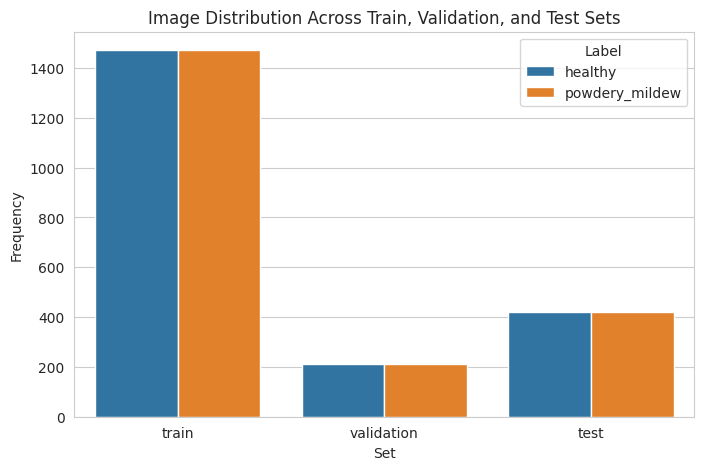

In [9]:
def count_images_per_set(data_dir, labels, output_dir, figsize=(8, 5)):
    """
    Counts the number of images in train, validation, and test sets for each label, 
    and creates a bar plot showing the distribution.
    
    Args:
    - data_dir: Directory where the datasets (train, validation, test) are stored.
    - labels: List of labels/categories in the dataset.
    - output_dir: Directory where the output plot will be saved.
    - figsize: Size of the plot figure.
    
    Returns:
    - A bar plot showing the image distribution in train, validation, and test sets.
    """
    # Initialize an empty DataFrame to store counts
    image_counts = pd.DataFrame([])
    
    # Iterate over train, validation, and test sets
    for dataset in ['train', 'validation', 'test']:
        for label in labels:
            # Count the number of images for each label in each set
            num_images = len(os.listdir(f"{data_dir}/{dataset}/{label}"))
            image_counts = image_counts.append(pd.Series({
                'Set': dataset,
                'Label': label,
                'Frequency': num_images
            }), ignore_index=True)
            
            # Print the count of images for each set and label
            print(f"{dataset} - {label}: {num_images} images")
    
    # Plot the distribution using Seaborn
    sns.set_style("whitegrid")
    plt.figure(figsize=figsize)
    sns.barplot(data=image_counts, x='Set', y='Frequency', hue='Label')
    plt.title("Image Distribution Across Train, Validation, and Test Sets")
    
    # Save the plot
    output_path = f"{output_dir}/image_distribution.png"
    plt.savefig(output_path, bbox_inches='tight', dpi=150)
    plt.show()

# Example usage
count_images_per_set(data_dir=my_data_dir, labels=labels, output_dir=file_path, figsize=(8, 5))


---

## Data Augmentation

In [10]:
# Initialize ImageDataGenerator for augmentation
def create_augmented_data_generator():
    """
    Creates an ImageDataGenerator object with specified augmentations for 
    training dataset. Applies rotation, shift, zoom, shear, and horizontal flip 
    to artificially increase the size and variability of the training set.

    Returns:
    --------
    ImageDataGenerator : A Keras ImageDataGenerator instance with augmentations.
    """
    augmented_data_gen = ImageDataGenerator(
        rotation_range=15,  
        width_shift_range=0.15,  
        height_shift_range=0.15,
        shear_range=0.2,  
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,  
        fill_mode='reflect',  
        rescale=1./255  
    )
    return augmented_data_gen

# Function to create datasets
def load_dataset(generator, path, image_size, batch_size, shuffle=True, mode='binary'):
    """
    Loads the dataset from the specified directory using a given ImageDataGenerator.

    Parameters:
    -----------
    generator : ImageDataGenerator
        The data generator to apply augmentations or preprocessing.
    path : str
        Path to the dataset directory.
    image_size : tuple
        Target size to resize the images (height, width).
    batch_size : int
        Number of images to process in each batch.
    shuffle : bool, optional
        Whether to shuffle the data before feeding it to the model (default is True).
    mode : str, optional
        Determines the type of classification ('binary' by default).

    Returns:
    --------
    DirectoryIterator : Keras DirectoryIterator
        An iterator over the dataset directory.
    """
    dataset = generator.flow_from_directory(
        path,
        target_size=image_size,
        color_mode='rgb',
        batch_size=batch_size,
        class_mode=mode,
        shuffle=shuffle
    )
    return dataset

image_size = (100, 100)  
batch_size = 32  

# Create generators
train_data_gen = create_augmented_data_generator()
val_test_data_gen = ImageDataGenerator(rescale=1./255)  # For validation and test, no augmentation needed

# Load datasets
train_set = load_dataset(train_data_gen, train_path, image_size, batch_size)
validation_set = load_dataset(val_test_data_gen, val_path, image_size, batch_size, shuffle=False)
test_set = load_dataset(val_test_data_gen, test_path, image_size, batch_size, shuffle=False)

# Print class indices for reference
print("Training set class indices:", train_set.class_indices)
print("Validation set class indices:", validation_set.class_indices)
print("Test set class indices:", test_set.class_indices)


Found 2944 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 844 images belonging to 2 classes.
Training set class indices: {'healthy': 0, 'powdery_mildew': 1}
Validation set class indices: {'healthy': 0, 'powdery_mildew': 1}
Test set class indices: {'healthy': 0, 'powdery_mildew': 1}


### Visualizing and Inspecting Augmented Images and Saving Class Indices

Displaying 3 sample images from the Training set:
Image batch shape: (32, 100, 100, 3)


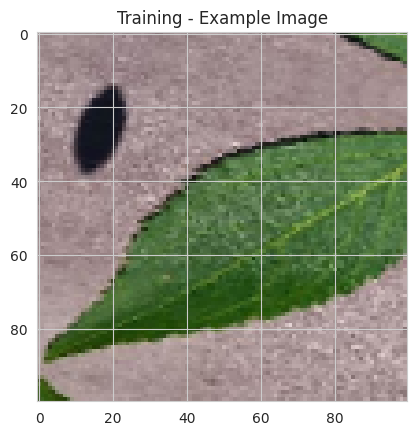

Image batch shape: (32, 100, 100, 3)


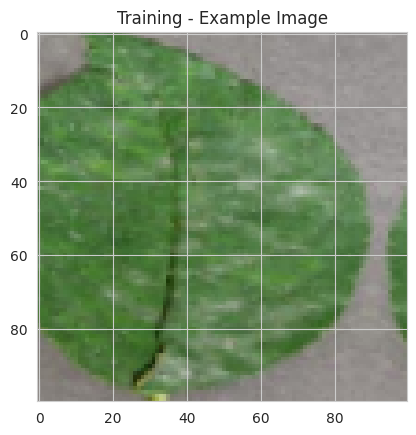

Image batch shape: (32, 100, 100, 3)


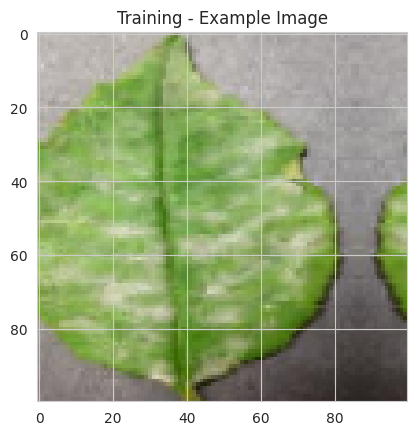

Displaying 3 sample images from the Validation set:
Image batch shape: (32, 100, 100, 3)


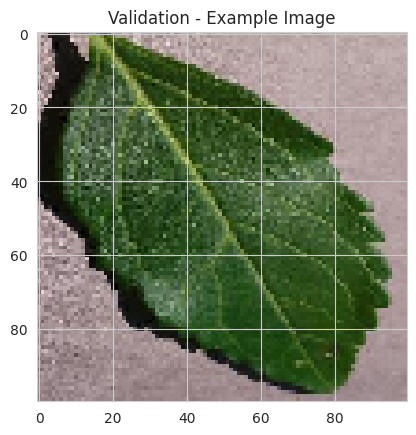

Image batch shape: (32, 100, 100, 3)


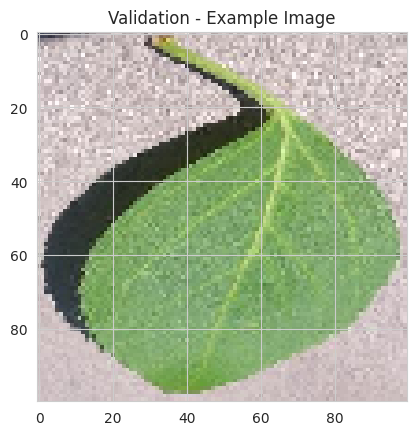

Image batch shape: (32, 100, 100, 3)


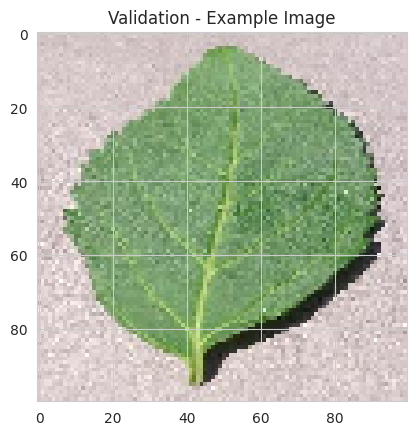

Displaying 3 sample images from the Test set:
Image batch shape: (32, 100, 100, 3)


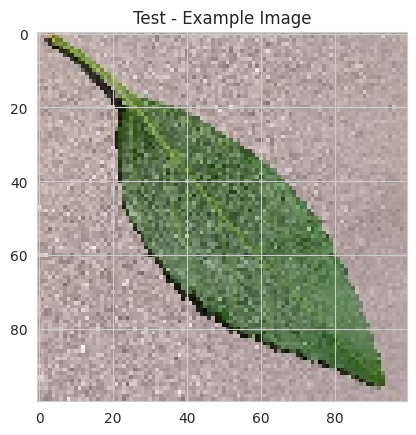

Image batch shape: (32, 100, 100, 3)


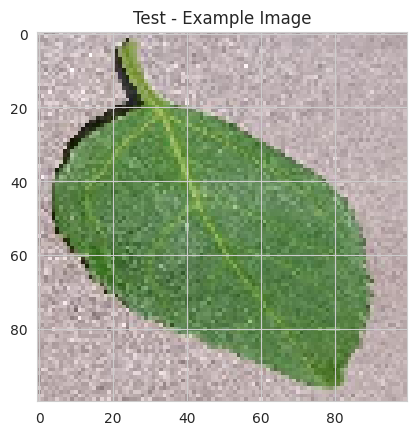

Image batch shape: (32, 100, 100, 3)


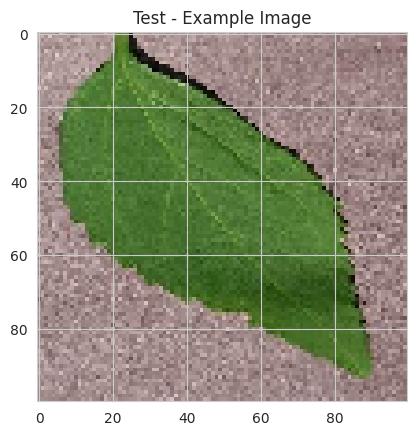

Class indices saved to outputs/class_indices.pkl


In [11]:
# Function to plot and display sample images from a dataset
def plot_sample_images(dataset, title, num_images=3):
    """
    Displays a set of images from a given dataset for visual inspection.
    
    Parameters:
    -----------
    dataset : DirectoryIterator
        The dataset from which to extract images (train_set, validation_set, test_set).
    title : str
        Title for the plot.
    num_images : int, optional
        The number of images to display (default is 3).
    """
    print(f"Displaying {num_images} sample images from the {title} set:")
    for _ in range(num_images):
        img_batch, label_batch = dataset.next()  # Get the next batch of images and labels
        print(f"Image batch shape: {img_batch.shape}")  # Print image shape for verification
        plt.imshow(img_batch[0])  # Show the first image in the batch
        plt.title(f"{title} - Example Image")  # Add a title to the plot
        plt.show()  # Display the image

# Plot augmented training images
plot_sample_images(train_set, "Training", num_images=3)

# Plot augmented validation images
plot_sample_images(validation_set, "Validation", num_images=3)

# Plot augmented test images
plot_sample_images(test_set, "Test", num_images=3)

# Function to save class indices
def save_class_indices(indices, file_path):
    """
    Saves class indices (e.g., {'healthy': 0, 'powdery_mildew': 1}) to a .pkl file for future reference.
    
    Parameters:
    -----------
    indices : dict
        A dictionary containing the class labels and their corresponding indices.
    file_path : str
        The directory path where the file will be saved.
    """
    joblib.dump(value=indices, filename=f"{file_path}/class_indices.pkl")
    print(f"Class indices saved to {file_path}/class_indices.pkl")

# Save class indices for reference
save_class_indices(train_set.class_indices, file_path="outputs") 


---

## Model creation

* Model

In [12]:

def build_cnn_model():
    """
    Builds and compiles a Convolutional Neural Network (CNN) model for binary image classification.
    
    Returns:
    --------
    model : keras.Sequential
        Compiled CNN model ready for training.
    """
    # Initialize Sequential model
    model = Sequential()

    # Add first convolutional block
    model.add(Conv2D(32, (3, 3), input_shape=image_shape, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Add second convolutional block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Add third convolutional block 
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Add fully connected layer after flattening
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))

    # Add dropout to prevent overfitting
    model.add(Dropout(0.4)) 

    # Add output layer with sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model using Adam optimizer and binary crossentropy
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


* Model Summary

In [13]:
build_cnn_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0

2024-09-24 16:55:29.305208: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


* Early stopping

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

* Fit model for model training

In [15]:
model = build_cnn_model()
# Train the model
model.fit(
    train_set,
    epochs=30, 
    steps_per_epoch=len(train_set.classes) // batch_size,
    validation_data=validation_set,
    callbacks=[early_stopping],
    verbose=1
)


2024-09-24 16:55:40.186578: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
92/92 [==============================] - 31s 324ms/step - loss: 0.5271 - accuracy: 0.7174 - val_loss: 0.1788 - val_accuracy: 0.9429
Epoch 2/30
92/92 [==============================] - 30s 323ms/step - loss: 0.1442 - accuracy: 0.9511 - val_loss: 0.0850 - val_accuracy: 0.9881
Epoch 3/30
92/92 [==============================] - 29s 320ms/step - loss: 0.0540 - accuracy: 0.9847 - val_loss: 0.0833 - val_accuracy: 0.9857
Epoch 4/30
92/92 [==============================] - 42s 458ms/step - loss: 0.0385 - accuracy: 0.9891 - val_loss: 0.0486 - val_accuracy: 0.9905
Epoch 5/30
92/92 [==============================] - 31s 335ms/step - loss: 0.0242 - accuracy: 0.9939 - val_loss: 0.0344 - val_accuracy: 0.9905
Epoch 6/30
92/92 [==============================] - 37s 400ms/step - loss: 0.0525 - accuracy: 0.9827 - val_loss: 0.0241 - val_accuracy: 0.9929
Epoch 7/30
92/92 [==============================] - 45s 488ms/step - loss: 0.0238 - accuracy: 0.9908 - val_loss: 0.0209 - val_accuracy: 0.9905

### Save model

In [16]:
model.save('outputs/v1/mildew_model_v1.h5')

---

# Model Perfomance

---

## Visualizing Model Learning Curves

<Figure size 1000x500 with 0 Axes>

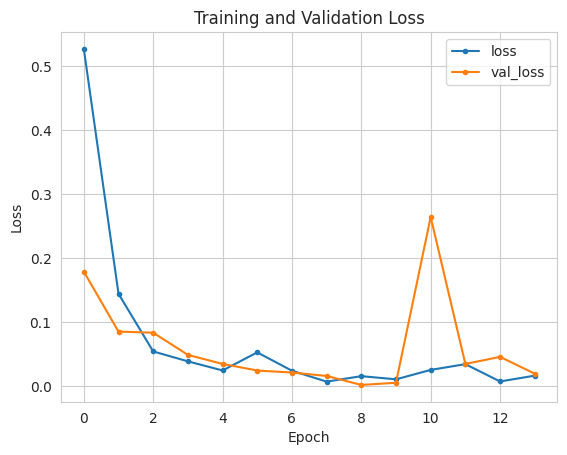

<Figure size 1000x500 with 0 Axes>

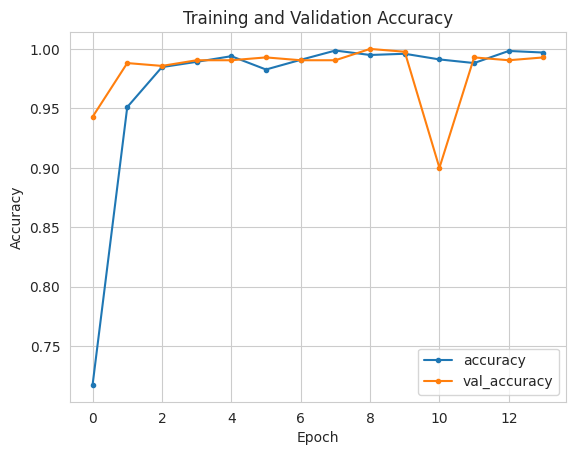

In [17]:
# Function to plot training history
def plot_training_curves(history, save_dir):
    """
    Plots the learning curves for loss and accuracy based on the model's training history.
    
    Parameters:
    -----------
    history : keras.callbacks.History
        The history object returned by model.fit(), containing loss and accuracy values.
    save_dir : str
        Directory where the plots will be saved.
    """
    # Convert history to DataFrame for easier plotting
    history_df = pd.DataFrame(history.history)

    # Set plot style
    sns.set_style('whitegrid')

    # Create a subdirectory for saving the plots
    plot_dir = f'{save_dir}/training_plots'
    os.makedirs(plot_dir, exist_ok=True)  # Ensure the directory exists

    # Plot Loss curves
    plt.figure(figsize=(10, 5))
    history_df[['loss', 'val_loss']].plot(style='.-')
    plt.title("Training and Validation Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.savefig(f'{plot_dir}/training_vs_validation_loss.png', bbox_inches='tight', dpi=150)
    plt.show()

    # Plot Accuracy curves
    plt.figure(figsize=(10, 5))
    history_df[['accuracy', 'val_accuracy']].plot(style='.-')
    plt.title("Training and Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.savefig(f'{plot_dir}/training_vs_validation_accuracy.png', bbox_inches='tight', dpi=150)
    plt.show()

# Example usage
plot_training_curves(model.history, save_dir='outputs')


## Model evaluation 

* Load saved model

In [19]:
model = load_model('outputs/v1/mildew_model_v1.h5')

* Evaluate the model on the test set

In [20]:
evaluation = model.evaluate(test_set)

27/27 [==============================] - 5s 177ms/step - loss: 0.0044 - accuracy: 0.9976


* Show results

In [22]:
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")

Test Loss: 0.004357393365353346
Test Accuracy: 0.9976303577423096


* Save evaluation pickle

In [21]:
joblib.dump(value=evaluation, filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

## Predicting Class of New Images

In [ ]:
def load_random_image(test_dir, labels, img_shape, pointer=0):
    """
    Load a random image from the test set, resize it, and return the image.
    
    Args:
    - test_dir (str): Path to the test dataset.
    - labels (list): List of labels for the dataset (healthy, powdery mildew).
    - img_shape (tuple): Target size for the image.
    - pointer (int): Index of the image to load from the dataset.
    
    Returns:
    - PIL image: Loaded image in PIL format.
    """
    label = labels[0]  
    img_path = os.path.join(test_dir, label, os.listdir(os.path.join(test_dir, label))[pointer])
    pil_image = image.load_img(img_path, target_size=img_shape, color_mode='rgb')
    
    print(f"Image shape: {pil_image.size}, Image mode: {pil_image.mode}")
    return pil_image

def prepare_image_for_prediction(pil_image):
    """
    Convert a PIL image to an array and prepare it for model prediction.
    
    Args:
    - pil_image (PIL Image): Image loaded in PIL format.
    
    Returns:
    - Numpy array: Image ready for model prediction.
    """
    img_array = image.img_to_array(pil_image)
    img_array = np.expand_dims(img_array, axis=0) 
    return img_array

def predict_image_class(model, img_array, class_indices):
    """
    Predict the class of an image using the model.
    
    Args:
    - model (Keras model): Trained Keras model.
    - img_array (Numpy array): Image array ready for prediction.
    - class_indices (dict): Mapping of class indices to class names.
    
    Returns:
    - Tuple: Predicted probability and class.
    """
    pred_proba = model.predict(img_array)[0,0]
    target_map = {v: k for k, v in class_indices.items()}
    pred_class = target_map[pred_proba > 0.5]
    
    if pred_class == target_map[0]:
        pred_proba = 1 - pred_proba
    
    return pred_proba, pred_class

* Predict class probabilities

In [ ]:
random_image = load_random_image(test_path, labels, image_shape, pointer=66)
prepared_image = prepare_image_for_prediction(random_image)
pred_proba, pred_class = predict_image_class(model, prepared_image, train_set.class_indices)

print(f"Predicted probability: {pred_proba}")
print(f"Predicted class: {pred_class}")